In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv("tweets.csv", encoding="ISO-8859-1")
df.head()

Unnamed: 0                                               text  favorited  \
0           1  RT @mrvelstan: literally nobody:\r\nme:\r\n\r\...      False   
1           2  RT @agntecarter: im emotional, sorry!!\r\n\r\...      False   
2           3  saving these bingo cards for tomorrow \r\n©\r\...      False   
3           4  RT @HelloBoon: Man these #AvengersEndgame ads ...      False   
4           5  RT @Marvel: We salute you, @ChrisEvans! #Capta...      False   

   favoriteCount replyToSN              created  truncated  replyToSID  \
0              0       NaN  2019-04-23 10:43:30      False         NaN   
1              0       NaN  2019-04-23 10:43:30      False         NaN   
2              0       NaN  2019-04-23 10:43:30      False         NaN   
3              0       NaN  2019-04-23 10:43:29      False         NaN   
4              0       NaN  2019-04-23 10:43:29      False         NaN   

                    id  replyToUID  \
0  1120639328034676737         NaN   
1  1120639325199196160         NaN   
2  1120639324683292674         NaN   
3  1120639323328540672         NaN   
4  1120639321571074048         NaN   

                                        statusSource   screenName  \
0  <a href="http://twitter.com/download/android" ...    DavidAc96   
1  <a href="http://twitter.com/download/iphone" r...      NRmalaa   
2  <a href="http://twitter.com/download/iphone" r...     jijitsuu   
3  <a href="http://twitter.com/download/iphone" r...     SahapunB   
4  <a href="http://twitter.com/download/iphone" r...  stella22_97   

   retweetCount  isRetweet  retweeted  longitude  latitude  
0           637       True      False        NaN       NaN  
1           302       True      False        NaN       NaN  
2             0      False      False        NaN       NaN  
3         23781       True      False        NaN       NaN  
4         13067       True      False        NaN       NaN

In [3]:
df.info


<bound method DataFrame.info of        Unnamed: 0                                               text  \
0               1  RT @mrvelstan: literally nobody:\r\nme:\r\n\r\...   
1               2  RT @agntecarter: im emotional, sorry!!\r\n\r\...   
2               3  saving these bingo cards for tomorrow \r\n©\r\...   
3               4  RT @HelloBoon: Man these #AvengersEndgame ads ...   
4               5  RT @Marvel: We salute you, @ChrisEvans! #Capta...   
...           ...                                                ...   
14995       14996  RT @natsdany: First time                  Last...   
14996       14997  RT @MTVNEWS: The #AvengersEndgame cast has see...   
14997       14998  @SPICinemas kindly announce the approximate ti...   
14998       14999  RT @Marvel: We salute you, @ChrisEvans! #Capta...   
14999       15000  RT @Avengers: Welcome to the party, @RobertDow...   

       favorited  favoriteCount   replyToSN              created  truncated  \
0          False        

In [4]:
df = df.dropna(subset=['text'])
df['text'].fillna('Unknown', inplace=True)

In [5]:
df.isnull().sum()

Unnamed: 0           0
text                 0
favorited            0
favoriteCount        0
replyToSN        14603
created              0
truncated            0
replyToSID       14631
id                   0
replyToUID       14603
statusSource         0
screenName           0
retweetCount         0
isRetweet            0
retweeted            0
longitude        14996
latitude         14996
dtype: int64

In [6]:
df.columns

Index(['Unnamed: 0', 'text', 'favorited', 'favoriteCount', 'replyToSN',
       'created', 'truncated', 'replyToSID', 'id', 'replyToUID',
       'statusSource', 'screenName', 'retweetCount', 'isRetweet', 'retweeted',
       'longitude', 'latitude'],
      dtype='object')

In [7]:
text_df = df.drop(['Unnamed: 0',  'favorited', 'favoriteCount', 'replyToSN',
       'created', 'truncated', 'replyToSID', 'id', 'replyToUID',
       'statusSource', 'screenName', 'retweetCount', 'isRetweet', 'retweeted',
       'longitude', 'latitude'], axis=1)
text_df.head()

text
0  RT @mrvelstan: literally nobody:\r\nme:\r\n\r\...
1  RT @agntecarter: im emotional, sorry!!\r\n\r\...
2  saving these bingo cards for tomorrow \r\n©\r\...
3  RT @HelloBoon: Man these #AvengersEndgame ads ...
4  RT @Marvel: We salute you, @ChrisEvans! #Capta...

In [8]:
print(text_df['text'].iloc[0],'\n')
print(text_df['text'].iloc[1],'\n')
print(text_df['text'].iloc[2],'\n')
print(text_df['text'].iloc[3],'\n')
print(text_df['text'].iloc[4],'\n')

RT @mrvelstan: literally nobody:
me:

#AvengersEndgame https://t.co/LR9kFwfD5c 

RT @agntecarter: im emotional, sorry!!

2014 x 2019
#blackwidow
#captainamerica https://t.co/xcwkCMw18w 

saving these bingo cards for tomorrow 
©
 #AvengersEndgame https://t.co/d6For0jwRb 

RT @HelloBoon: Man these #AvengersEndgame ads are everywhere https://t.co/Q0lNf5eJsX 

RT @Marvel: We salute you, @ChrisEvans! #CaptainAmerica #AvengersEndgame https://t.co/VlPEpnXYgm 



In [9]:
import re

def preprocess_tweet(sen):
    '''Cleans sentence data, handling NaN, and removing extra whitespaces.'''
    
    # Check for NaN values
    if pd.isna(sen):
        return ""

    # Convert to lowercase
    sentence = sen.lower()
    sentence = re.sub(r"https\S+|www\S+https\S+", '',sentence, flags=re.MULTILINE)
    sentence = re.sub(r'\@w+|\#','',sentence)
    sentence = re.sub(r'[^\w\s]','',sentence)
    # Remove RT
    sentence = re.sub(r'^rt\s+', '', sentence)

    # Remove special characters, URLs, and usernames
    sentence = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", sentence)

    # Remove single characters
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    # Strip leading and trailing whitespace
    sentence = sentence.strip()
    sentence_tokens = word_tokenize(sentence)
    filtered_text = [w for w in sentence_tokens if not w in stop_words]
    return " ".join(filtered_text)
   

In [10]:
cleaned_tweets = []

for tweet in text_df['text']:
  cleaned_tweet = preprocess_tweet(tweet)
  cleaned_tweets.append(cleaned_tweet)

In [11]:
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [12]:
text_df['cleaned'] = pd.DataFrame(cleaned_tweets)
text_df.head(5)

text  \
0  RT @mrvelstan: literally nobody:\r\nme:\r\n\r\...   
1  RT @agntecarter: im emotional, sorry!!\r\n\r\...   
2  saving these bingo cards for tomorrow \r\n©\r\...   
3  RT @HelloBoon: Man these #AvengersEndgame ads ...   
4  RT @Marvel: We salute you, @ChrisEvans! #Capta...   

                                             cleaned  
0         mrvelstan literally nobody avengersendgame  
1  agntecarter im emotional sorry 2014 2019 black...  
2        saving bingo cards tomorrow avengersendgame  
3       helloboon man avengersendgame ads everywhere  
4  marvel salute chrisevans captainamerica avenge...

In [13]:
text_df['cleaned'].fillna('', inplace=True)

In [14]:
text_df['cleaned'] = text_df['cleaned'].apply(lambda x: stemming(x))

In [15]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\BRIJ
[nltk_data]     BRIJKISHOR\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [16]:
import pandas as pd

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

# Assuming you have a DataFrame called text_df with a 'cleaned' column
# Convert the 'cleaned' column to strings
text_df['cleaned'] = text_df['cleaned'].astype(str)

# Apply sentiment analysis using TextBlob
text_df[['polarity', 'subjectivity']] = text_df['cleaned'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

# Perform sentiment analysis using VADER
analyzer = SentimentIntensityAnalyzer()
text_df['vader_score'] = text_df['cleaned'].apply(lambda text: analyzer.polarity_scores(text)['compound'])

for index, row in text_df['cleaned'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if comp <= -0.05:
        text_df.loc[index, 'sentiment'] = "negative"
    elif comp >= 0.05:
        text_df.loc[index, 'sentiment'] = "positive"
    else:
        text_df.loc[index, 'sentiment'] = "neutral"
    text_df.loc[index, 'neg'] = neg
    text_df.loc[index, 'neu'] = neu
    text_df.loc[index, 'pos'] = pos
    text_df.loc[index, 'compound'] = comp

text_df.head(5)

text  \
0  RT @mrvelstan: literally nobody:\r\nme:\r\n\r\...   
1  RT @agntecarter: im emotional, sorry!!\r\n\r\...   
2  saving these bingo cards for tomorrow \r\n©\r\...   
3  RT @HelloBoon: Man these #AvengersEndgame ads ...   
4  RT @Marvel: We salute you, @ChrisEvans! #Capta...   

                                             cleaned  polarity  subjectivity  \
0         mrvelstan literally nobody avengersendgame      0.00         0.000   
1  agntecarter im emotional sorry 2014 2019 black...     -0.25         0.825   
2        saving bingo cards tomorrow avengersendgame      0.00         0.000   
3       helloboon man avengersendgame ads everywhere      0.00         0.000   
4  marvel salute chrisevans captainamerica avenge...      0.00         0.000   

   vader_score sentiment    neg    neu    pos  compound  
0       0.0000   neutral  0.000  1.000  0.000    0.0000  
1       0.0772  positive  0.146  0.674  0.180    0.0772  
2       0.0000   neutral  0.000  1.000  0.000    0.0000  
3       0.0000   neutral  0.000  1.000  0.000    0.0000  
4       0.4215  positive  0.000  0.588  0.412    0.4215

<AxesSubplot:xlabel='sentiment', ylabel='count'>

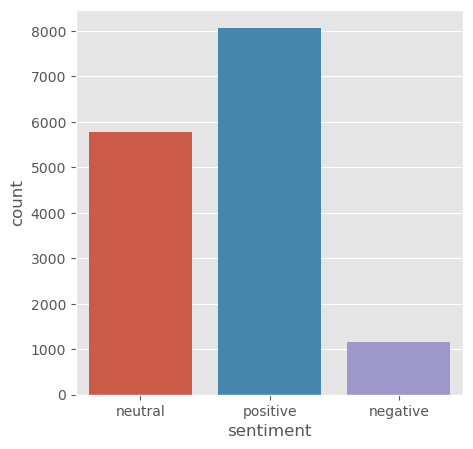

In [17]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='sentiment', data = text_df)

Text(0.5, 1.0, 'Distribution of sentiments')

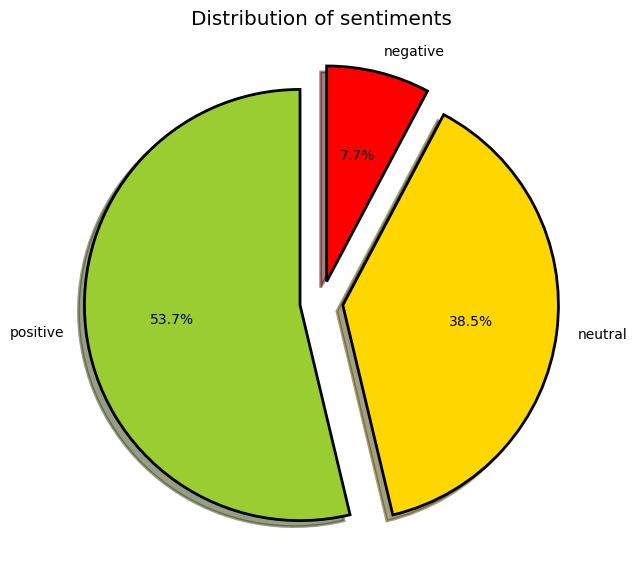

In [18]:
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = text_df['sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

In [19]:
neu_tweets = text_df[text_df.sentiment == 'neutral']
neu_tweets = neu_tweets.sort_values(['polarity'], ascending= False)
neu_tweets.head()

text  \
3413   RT @SGComicCon: D-1 till #AvengersEndgame !! W...   
8161   RT @mithunraman: #Kanchana3 after smashing 30 ...   
11320  RT @mithunraman: #Kanchana3 after smashing 30 ...   
14091  RT @Avengers: Elizabeth Olsen brings the magic...   
8584   RT @Avengers: Elizabeth Olsen brings the magic...   

                                                 cleaned  polarity  \
3413   sgcomiccon d1 till avengersendgame whos catchi...   0.60000   
8161   mithunraman kanchana3 smashing 30 cr 3 days ho...   0.53125   
11320  mithunraman kanchana3 smashing 30 cr 3 days ho...   0.53125   
14091  avengers elizabeth olsen brings magic u2728 sc...   0.50000   
8584   avengers elizabeth olsen brings magic u2728 sc...   0.50000   

       subjectivity  vader_score sentiment  neg    neu    pos  compound  
3413           0.90       0.0258   neutral  0.0  0.916  0.084    0.0258  
8161           0.75       0.0000   neutral  0.0  1.000  0.000    0.0000  
11320          0.75       0.0000   neutral  0.0  1.000  0.000    0.0000  
14091          1.00       0.0000   neutral  0.0  1.000  0.000    0.0000  
8584           1.00       0.0000   neutral  0.0  1.000  0.000    0.0000

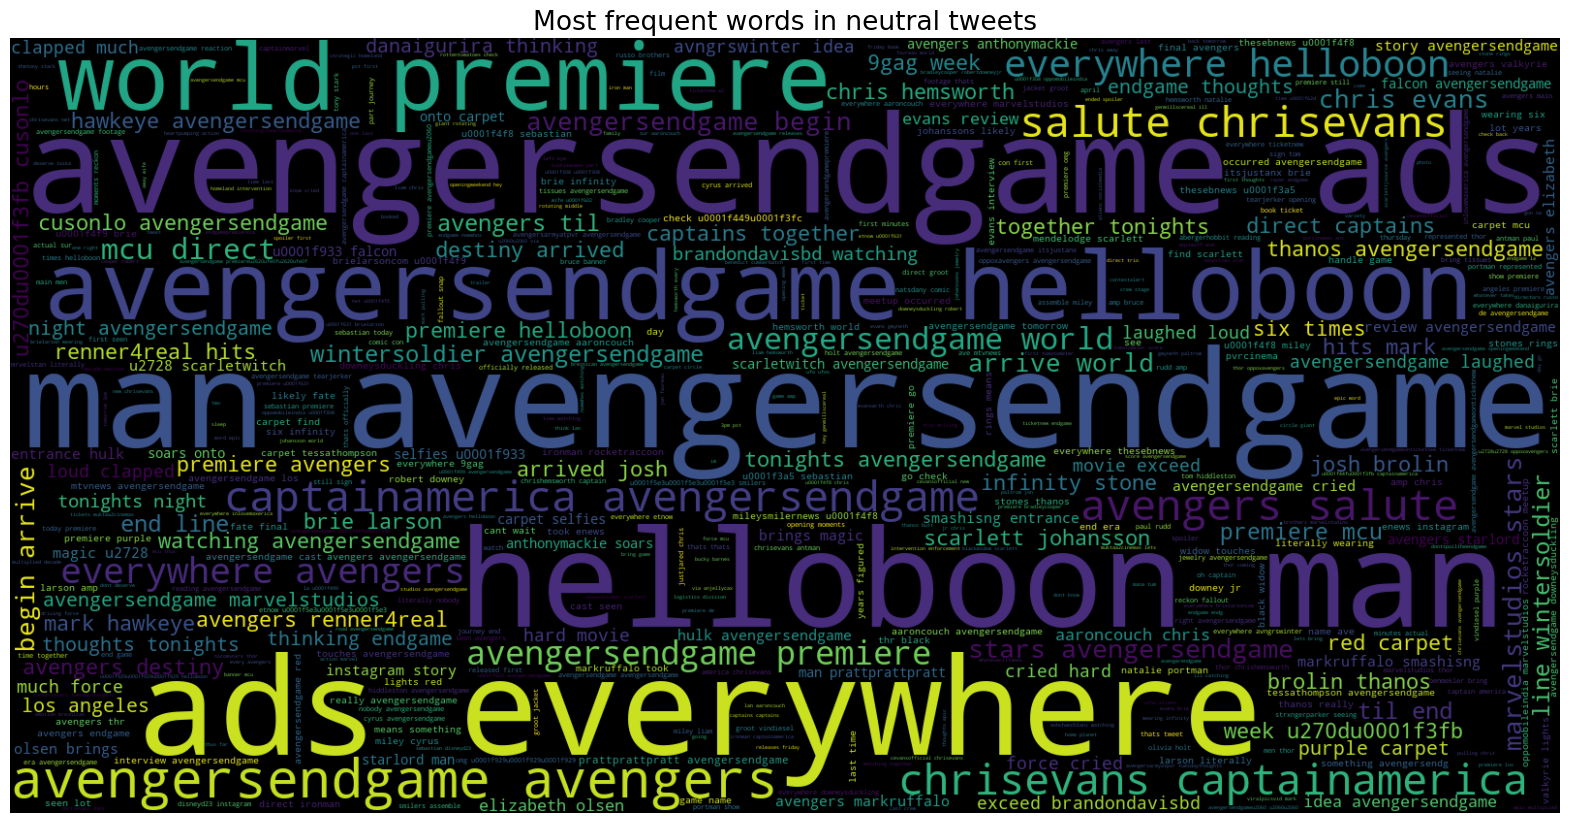

In [20]:
text = ' '.join([word for word in neu_tweets['cleaned']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in neutral tweets', fontsize=19)
plt.show()

In [21]:
pos_tweets = text_df[text_df.sentiment == 'positive']
pos_tweets = pos_tweets.sort_values(['polarity'], ascending= False)
pos_tweets.head()

text  \
8166   RT @Marvel: Josh Brolin, perfectly balanced. #...   
6927   RT @Marvel: Josh Brolin, perfectly balanced. #...   
9995   RT @sonia06loach: @_PVRCinemas A2. Captain Ame...   
9907   no one:\r\nMe:STOP TALKING ABOUT BENEDICT HE'S...   
12551  RT @Marvel: Josh Brolin, perfectly balanced. #...   

                                                 cleaned  polarity  \
8166   marvel josh brolin perfectly balanced thanos a...       1.0   
6927   marvel josh brolin perfectly balanced thanos a...       1.0   
9995   sonia06loach pvrcinemas a2 captain americas be...       1.0   
9907   one mestop talking benedict hes perfect god wi...       1.0   
12551  marvel josh brolin perfectly balanced thanos a...       1.0   

       subjectivity  vader_score sentiment  neg    neu    pos  compound  
8166            1.0       0.7906  positive  0.0  0.417  0.583    0.7906  
6927            1.0       0.7906  positive  0.0  0.417  0.583    0.7906  
9995            0.3       0.8126  positive  0.0  0.575  0.425    0.8126  
9907            1.0       0.8637  positive  0.0  0.485  0.515    0.8637  
12551           1.0       0.7906  positive  0.0  0.417  0.583    0.7906

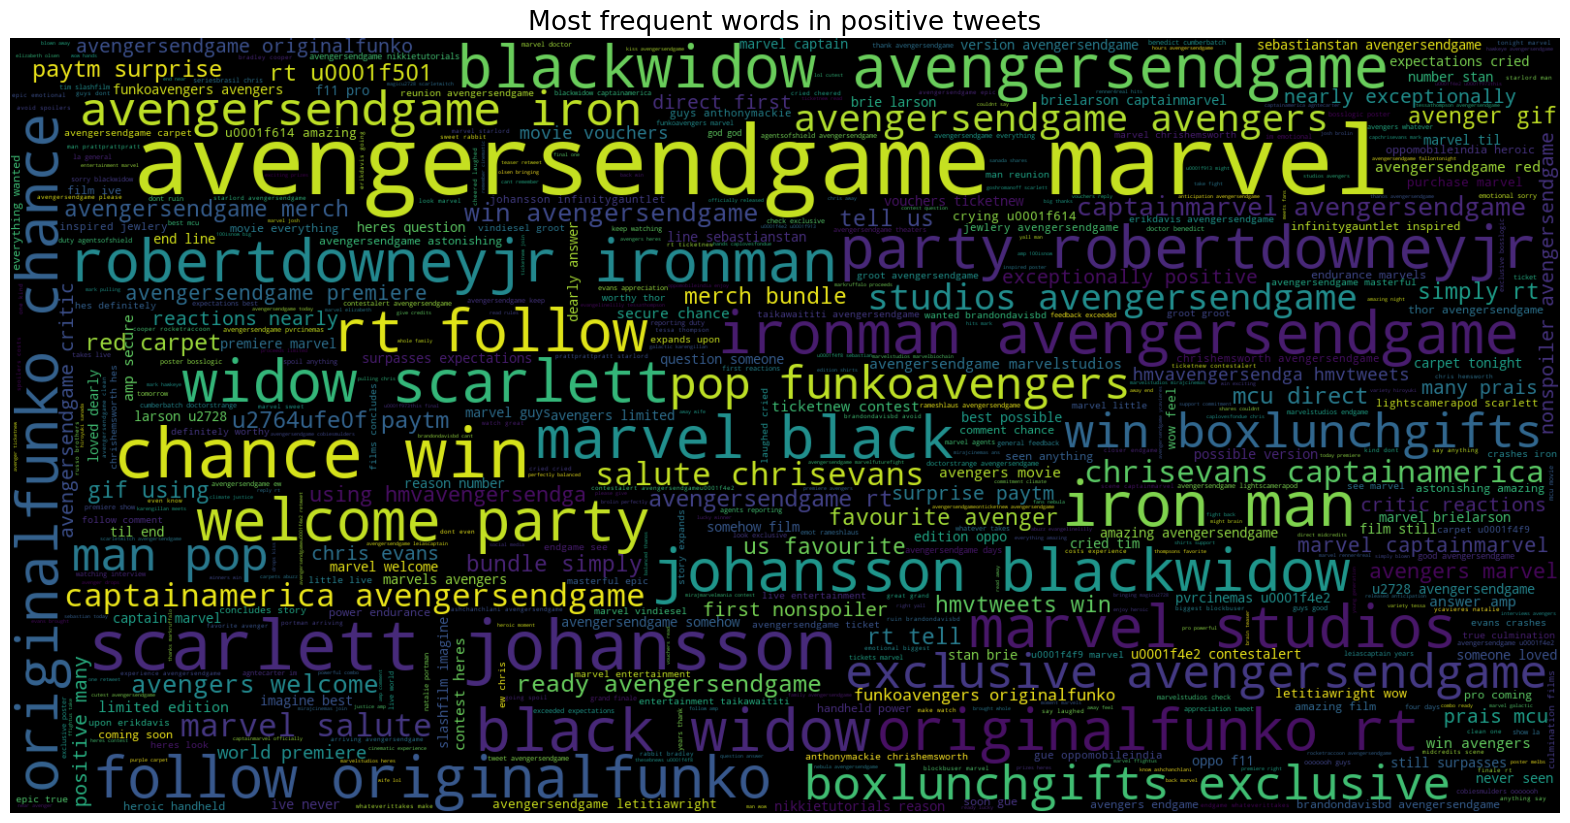

In [22]:
pos_tweets = pos_tweets.dropna(subset=['cleaned'])
text = ' '.join([word for word in pos_tweets['cleaned']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive tweets', fontsize=19)
plt.show()

In [23]:
neg_tweets = text_df[text_df.sentiment == 'negative']
neg_tweets = neg_tweets.sort_values(['polarity'], ascending= False)
neg_tweets.head()

text  \
13740  RT @TheNerdsofColor: Nothing but the best for ...   
13706  RT @TheNerdsofColor: Nothing but the best for ...   
10659  @TicketNew A2) Zen-Whoberi<U+0001F30F>\r\n\r\n...   
2186   #Avengersendgame I don't know but it's not as ...   
7418   RT @targrycn: honestly chris evans saying he c...   

                                                 cleaned  polarity  \
13740  thenerdsofcolor nothing best captains avengers...       1.0   
13706  thenerdsofcolor nothing best captains avengers...       1.0   
10659  ticketnew a2 zenwhoberiu0001f30f avengersendga...       0.7   
2186   avengersendgame dont know good people saying i...       0.7   
7418   targrycn honestly chris evans saying cried six...       0.6   

       subjectivity  vader_score sentiment    neg    neu    pos  compound  
13740           0.3      -0.5216  negative  0.325  0.675  0.000   -0.5216  
13706           0.3      -0.5216  negative  0.325  0.675  0.000   -0.5216  
10659           0.9      -0.0747  negative  0.300  0.417  0.283   -0.0747  
2186            0.6      -0.7435  negative  0.441  0.559  0.000   -0.7435  
7418            0.9      -0.2960  negative  0.257  0.594  0.149   -0.2960

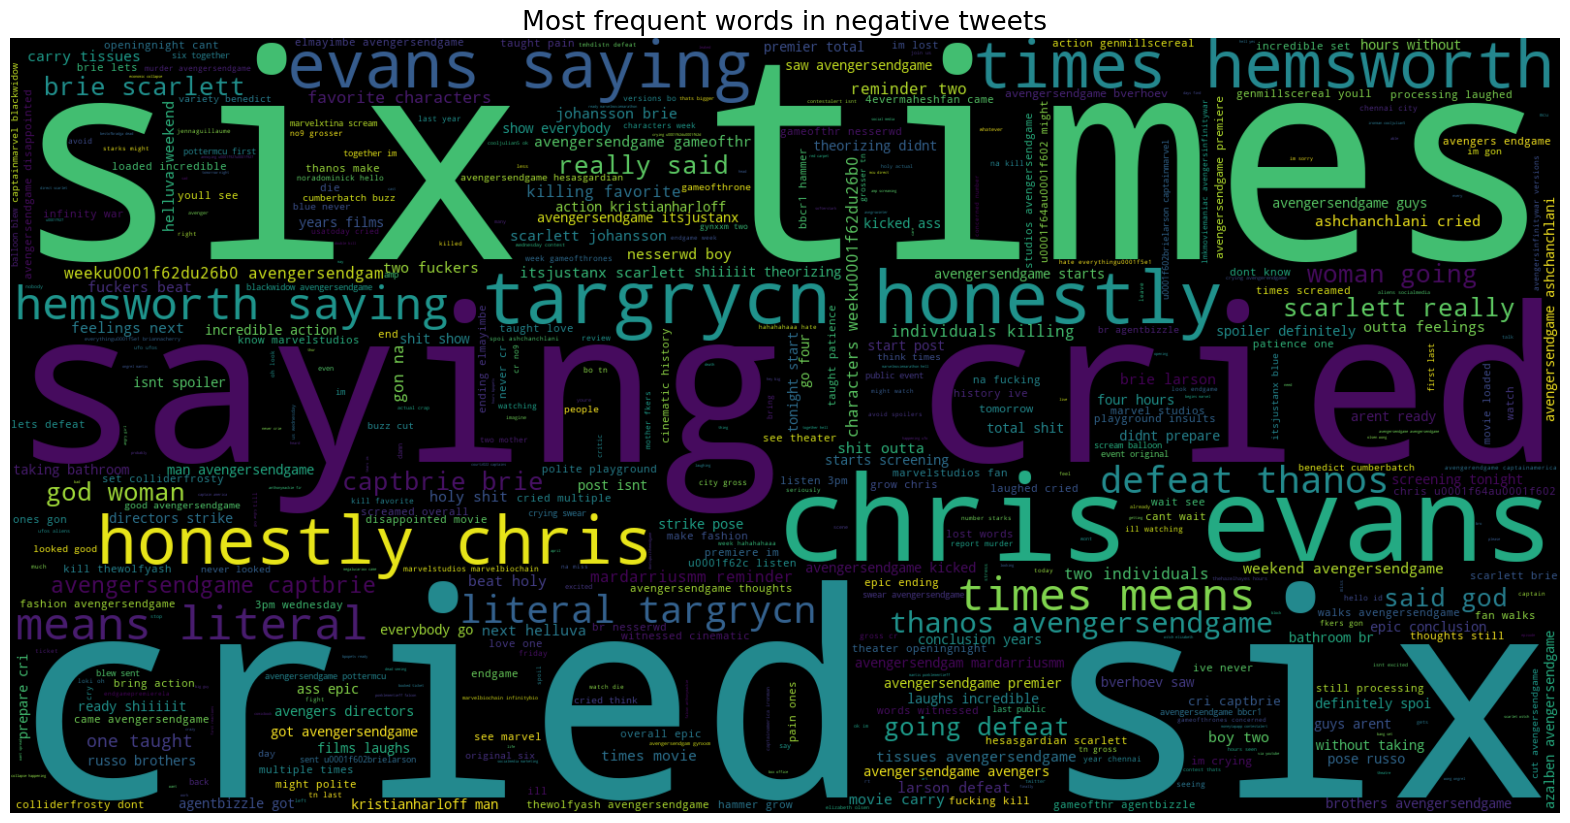

In [24]:
text = ' '.join([word for word in neg_tweets['cleaned']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in negative tweets', fontsize=19)
plt.show()

In [25]:
vect = CountVectorizer(ngram_range=(1,2)).fit(text_df['cleaned'])

In [26]:
feature_names = vect.get_feature_names_out()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features:\n {}".format(feature_names[:20]))

Number of features: 20311

First 20 features:
 ['0215' '0215 pm' '042219' '042219 avengersendgame' '042219 new' '05'
 '0553482918' '0553482918 dm' '0917lifestyle'
 '0917lifestyle avengersendgame' '0ffl' '0ffl came' '10' '10 anyone'
 '10 bro' '10 captainamerica' '10 days' '10 exclusive' '10 hours' '10 mad']


In [27]:
X = text_df['cleaned']
Y = text_df['sentiment']
X = vect.transform(X)

In [28]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [29]:
print("Size of x_train:", (x_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test:", (x_test.shape))
print("Size of y_test:", (y_test.shape))

Size of x_train: (12000, 20311)
Size of y_train: (12000,)
Size of x_test: (3000, 20311)
Size of y_test: (3000,)


In [30]:
import warnings

warnings.filterwarnings('ignore')

In [31]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg_pred = logreg.predict(x_test)
logreg_acc = accuracy_score(logreg_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 97.90%


In [32]:
print(confusion_matrix(y_test, logreg_pred))
print("\n")
print(classification_report(y_test, logreg_pred))

[[ 212   19    8]
 [   1 1154    6]
 [   2   27 1571]]


              precision    recall  f1-score   support

    negative       0.99      0.89      0.93       239
     neutral       0.96      0.99      0.98      1161
    positive       0.99      0.98      0.99      1600

    accuracy                           0.98      3000
   macro avg       0.98      0.95      0.97      3000
weighted avg       0.98      0.98      0.98      3000



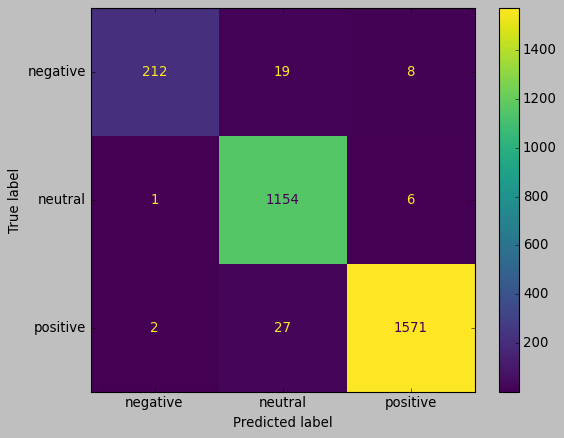

In [33]:
style.use('classic')
cm = confusion_matrix(y_test, logreg_pred, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=logreg.classes_)
disp.plot()

In [34]:
from sklearn.model_selection import GridSearchCV

In [35]:
param_grid={'C':[0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(LogisticRegression(), param_grid)
grid.fit(x_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [36]:
print("Best parameters:", grid.best_params_)

Best parameters: {'C': 10}


In [37]:
y_pred = grid.predict(x_test)

In [38]:
logreg_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 97.90%


In [39]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[ 214   18    7]
 [   1 1154    6]
 [   2   29 1569]]


              precision    recall  f1-score   support

    negative       0.99      0.90      0.94       239
     neutral       0.96      0.99      0.98      1161
    positive       0.99      0.98      0.99      1600

    accuracy                           0.98      3000
   macro avg       0.98      0.96      0.97      3000
weighted avg       0.98      0.98      0.98      3000



In [40]:
from sklearn.svm import LinearSVC

In [41]:
SVCmodel = LinearSVC()
SVCmodel.fit(x_train, y_train)

LinearSVC()

In [42]:
svc_pred = SVCmodel.predict(x_test)
svc_acc = accuracy_score(svc_pred, y_test)
print("test accuracy: {:.2f}%".format(svc_acc*100))

test accuracy: 98.00%


In [43]:
print(confusion_matrix(y_test, svc_pred))
print("\n")
print(classification_report(y_test, svc_pred))

[[ 216   16    7]
 [   1 1155    5]
 [   1   30 1569]]


              precision    recall  f1-score   support

    negative       0.99      0.90      0.95       239
     neutral       0.96      0.99      0.98      1161
    positive       0.99      0.98      0.99      1600

    accuracy                           0.98      3000
   macro avg       0.98      0.96      0.97      3000
weighted avg       0.98      0.98      0.98      3000



In [44]:
grid = {
    'C':[0.01, 0.1, 1, 10],
    'kernel':["linear","poly","rbf","sigmoid"],
    'degree':[1,3,5,7],
    'gamma':[0.01,1]
}
grid = GridSearchCV(SVCmodel, param_grid)
grid.fit(x_train, y_train)

GridSearchCV(estimator=LinearSVC(), param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [45]:
print("Best parameter:", grid.best_params_)

Best parameter: {'C': 10}


In [46]:
y_pred = grid.predict(x_test)

In [47]:
logreg_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 97.90%


In [48]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[ 216   17    6]
 [   2 1154    5]
 [   1   32 1567]]


              precision    recall  f1-score   support

    negative       0.99      0.90      0.94       239
     neutral       0.96      0.99      0.98      1161
    positive       0.99      0.98      0.99      1600

    accuracy                           0.98      3000
   macro avg       0.98      0.96      0.97      3000
weighted avg       0.98      0.98      0.98      3000



### experimental performanes

#### tokenization filtration and script validation

In [49]:
import re
from nltk.tokenize import word_tokenize
def preprocess_tweet(sen):
    '''Cleans sentence data, handling NaN, and removing extra whitespaces.'''
    
    # Check for NaN values
    if pd.isna(sen):
        return ""

    # Convert to lowercase
    sentence = sen.lower()
    sentence = re.sub(r"https\S+|www\S+https\S+", '',sentence, flags=re.MULTILINE)
    sentence = re.sub(r'\@w+|\#','',sentence)
    sentence = re.sub(r'[^\w\s]','',sentence)
    # Remove RT
    sentence = re.sub(r'^rt\s+', '', sentence)

    # Remove special characters, URLs, and usernames
    sentence = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", sentence)

    # Remove single characters
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    # Strip leading and trailing whitespace
    sentence = sentence.strip()
    sentence = word_tokenize(sentence)
    return sentence
   
    
a=preprocess_tweet(text)
print(a)

['thenerdsofcolor', 'nothing', 'best', 'captains', 'avengersendgame', 'avengers', 'captainamerica', 'captainmarvel', 'thenerdsofcolor', 'nothing', 'best', 'captains', 'avengersendgame', 'avengers', 'captainamerica', 'captainmarvel', 'ticketnew', 'a2', 'zenwhoberiu0001f30f', 'avengersendgameonticketnew', 'ticketnew', 'dont', 'miss', 'awesome', 'chance', 'grab', 'free', 'avengersendgame', 'dont', 'know', 'good', 'people', 'saying', 'infinity', 'war', 'age', 'ultron', 'targrycn', 'honestly', 'chris', 'evans', 'saying', 'cried', 'six', 'times', 'hemsworth', 'saying', 'cried', 'six', 'times', 'means', 'literal', 'targrycn', 'honestly', 'chris', 'evans', 'saying', 'cried', 'six', 'times', 'hemsworth', 'saying', 'cried', 'six', 'times', 'means', 'literal', 'targrycn', 'honestly', 'chris', 'evans', 'saying', 'cried', 'six', 'times', 'hemsworth', 'saying', 'cried', 'six', 'times', 'means', 'literal', 'targrycn', 'honestly', 'chris', 'evans', 'saying', 'cried', 'six', 'times', 'hemsworth', 'sayi

#### stopwords removal

In [50]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
sentence_tokens = word_tokenize(text)
filtered_text = [w for w in sentence_tokens if not w in stop_words]
cleaned_text = " ".join(filtered_text)
print(cleaned_text)

thenerdsofcolor nothing best captains avengersendgame avengers captainamerica captainmarvel thenerdsofcolor nothing best captains avengersendgame avengers captainamerica captainmarvel ticketnew a2 zenwhoberiu0001f30f avengersendgameonticketnew ticketnew dont miss awesome chance grab free avengersendgame dont know good people saying infinity war age ultron targrycn honestly chris evans saying cried six times hemsworth saying cried six times means literal targrycn honestly chris evans saying cried six times hemsworth saying cried six times means literal targrycn honestly chris evans saying cried six times hemsworth saying cried six times means literal targrycn honestly chris evans saying cried six times hemsworth saying cried six times means literal targrycn honestly chris evans saying cried six times hemsworth saying cried six times means literal targrycn honestly chris evans saying cried six times hemsworth saying cried six times means literal targrycn honestly chris evans saying cried

#### stemming

In [51]:

from nltk.stem import PorterStemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

s= stemming(cleaned_text)
print(s)

thenerdsofcolor nothing best captains avengersendgame avengers captainamerica captainmarvel thenerdsofcolor nothing best captains avengersendgame avengers captainamerica captainmarvel ticketnew a2 zenwhoberiu0001f30f avengersendgameonticketnew ticketnew dont miss awesome chance grab free avengersendgame dont know good people saying infinity war age ultron targrycn honestly chris evans saying cried six times hemsworth saying cried six times means literal targrycn honestly chris evans saying cried six times hemsworth saying cried six times means literal targrycn honestly chris evans saying cried six times hemsworth saying cried six times means literal targrycn honestly chris evans saying cried six times hemsworth saying cried six times means literal targrycn honestly chris evans saying cried six times hemsworth saying cried six times means literal targrycn honestly chris evans saying cried six times hemsworth saying cried six times means literal targrycn honestly chris evans saying cried

#### lemmatization

In [52]:
import nltk

# Download NLTK resources (if not already downloaded)
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\BRIJ
[nltk_data]     BRIJKISHOR\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\BRIJ BRIJKISHOR\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\BRIJ
[nltk_data]     BRIJKISHOR\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [53]:
# import these modules
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
s= lemmatizer.lemmatize(cleaned_text)
print(s)


thenerdsofcolor nothing best captains avengersendgame avengers captainamerica captainmarvel thenerdsofcolor nothing best captains avengersendgame avengers captainamerica captainmarvel ticketnew a2 zenwhoberiu0001f30f avengersendgameonticketnew ticketnew dont miss awesome chance grab free avengersendgame dont know good people saying infinity war age ultron targrycn honestly chris evans saying cried six times hemsworth saying cried six times means literal targrycn honestly chris evans saying cried six times hemsworth saying cried six times means literal targrycn honestly chris evans saying cried six times hemsworth saying cried six times means literal targrycn honestly chris evans saying cried six times hemsworth saying cried six times means literal targrycn honestly chris evans saying cried six times hemsworth saying cried six times means literal targrycn honestly chris evans saying cried six times hemsworth saying cried six times means literal targrycn honestly chris evans saying cried

#### morphological analysis

In [54]:
# Download NLTK resources (if not already downloaded)
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to C:\Users\BRIJ
[nltk_data]     BRIJKISHOR\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\BRIJ BRIJKISHOR\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [55]:
import nltk
from nltk.stem import WordNetLemmatizer

# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Input sentence for analysis
sentence =cleaned_text

# Tokenize the sentence into words
words = sentence_tokens

# Perform part-of-speech tagging
pos_tags = nltk.pos_tag(words)

# Initialize an empty list to store the analysis data
analysis_data = []

# Loop through each word and perform morphological analysis
for word, pos_tag in pos_tags:
    lemma = lemmatizer.lemmatize(word)
    morph_features = [f"{tag[0]}={tag[1]}" for tag in pos_tag.split("|")]
    morphological_features = "|".join(morph_features)
    analysis_data.append(
        {"Token": word, "Lemma": lemma, "POS": pos_tag, "Morphological Features": morphological_features}
    )

# Print the formatted output
print("Token   | Lemma    | POS ")
print("=" * 50)
for item in analysis_data:
    print(f"{item['Token']:<35} | {item['Lemma']:<35} | {item['POS']:<10} ")


Token   | Lemma    | POS 
thenerdsofcolor                     | thenerdsofcolor                     | NN         
nothing                             | nothing                             | NN         
best                                | best                                | JJS        
captains                            | captain                             | NNS        
avengersendgame                     | avengersendgame                     | JJ         
avengers                            | avenger                             | NNS        
captainamerica                      | captainamerica                      | VBP        
captainmarvel                       | captainmarvel                       | JJ         
thenerdsofcolor                     | thenerdsofcolor                     | NN         
nothing                             | nothing                             | NN         
best                                | best                                | JJS        
captai

#### n-gram model


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
# Create and train the model
def train_sentiment_model(data):
    X_train = text_df['cleaned']
    y_train = text_df['sentiment']
    
    vectorizer = CountVectorizer(ngram_range=(1, 3))
    X_train_vec = vectorizer.fit_transform(X_train)
    
    classifier = MultinomialNB()
    classifier.fit(X_train_vec, y_train)
    
    return vectorizer, classifier

# Predict sentiment for new text input
def predict_sentiment(text, vectorizer, classifier):
    X_test = [text]
    X_test_vec = vectorizer.transform(X_test)
    
    sentiment = classifier.predict(X_test_vec)
    
    return sentiment[0]

# Train the model
vectorizer, classifier = train_sentiment_model(df)

# Example usage: Predict sentiment for a new text
new_text = input('enter the new input:  ')
predicted_sentiment = predict_sentiment(new_text, vectorizer, classifier)
print(f"Predicted sentiment: {predicted_sentiment}")


In [ ]:
def generate_ngrams(text, n):
    words = text.split(" ")
    ngrams = [words[i:i + n] for i in range(len(words) - n + 1)]
    return ngrams

def main():
    # Input text
    text = sentence

    # Choose the value of n for n-grams
    n = 3

    # Generate n-grams
    ngrams = generate_ngrams(text, n)

    # Print the result
    print(f"{n}-grams:")
    for gram in ngrams:
        print(gram)

if __name__ == "__main__":
    main()


In [ ]:
def create_ngrams(sentence, n):
    words = sentence.split()
    ngrams = [tuple(words[i:i+n]) for i in range(len(words) - (n - 1))]
    return ngrams

def build_ngram_model(corpus, n):
    ngram_model = {}
    sentences = corpus.split('. ')
    for sentence in sentences:
        ngrams = create_ngrams(sentence, n)
        for ngram in ngrams:
            prefix, suffix = ngram[:-1], ngram[-1]
            ngram_model.setdefault(prefix, []).append(suffix)
    return ngram_model

def predict_next_word(prefix, ngram_model):
    possible_next_words = ngram_model.get(prefix, [])
    if possible_next_words:
        return max(set(possible_next_words), key=possible_next_words.count)
    return None

n = int(input("Enter the value of N: "))
corpus =cleaned_text

ngram_model = build_ngram_model(corpus, n)

input_prefix = tuple(input(f"Enter a prefix of length {n-1}: ").split())
predicted_word = predict_next_word(input_prefix, ngram_model)

if predicted_word:
    print(f"Predicted next word: {predicted_word}")
else:
    possible_prefix = max((prefix for prefix in ngram_model if prefix[:-1] == input_prefix[1:]), key=len, default=None)
    if possible_prefix:
        possible_next_words = ngram_model[possible_prefix]
        most_likely_word = max(set(possible_next_words), key=possible_next_words.count)
        print(f"No direct prediction. Predicting the most likely word based on frequency: {most_likely_word}")
    else:
        print("No prediction available for the given prefix.")


In [ ]:
#predict the sentiment
import nltk
from nltk import RegexpParser
from nltk.tokenize import word_tokenize

text = cleaned_text

# Tokenize the text into words
words = word_tokenize(text)

# Perform part-of-speech tagging
pos_tags = nltk.pos_tag(words)
# Define a grammar for noun phrases (NP)
grammar = r"""
    NP: {<DT>?<JJ>*<NN>}  # Chunk sequences of determiners, adjectives, and nouns
"""
# Create a chunk parser with the defined grammar
chunk_parser = RegexpParser(grammar)
# Parse the POS-tagged words to find noun phrases
tree = chunk_parser.parse(pos_tags)
print(tree)




#### POS Tagging


In [ ]:
import nltk
from nltk.tokenize import word_tokenize
text = cleaned_text

# Tokenize the text into words
sentence_tokens = word_tokenize(text)
words = sentence_tokens

# Perform POS tagging
pos_tags = nltk.pos_tag(words)

# Print the POS tags
print("Word  |  POS Tag")
print("-" * 15)
for word, pos_tag in pos_tags:
    print(f"{word:<30} | {pos_tag}")


#### chunking of the text

In [ ]:
import nltk
from nltk import RegexpParser
from nltk.tokenize import word_tokenize
nltk.download('punkt')

text = cleaned_text

# Tokenize the text into words
sentence_tokens = word_tokenize(text)
words= sentence_tokens

# Perform part-of-speech tagging
pos_tags = nltk.pos_tag(words)

# Define a grammar for noun phrases (NP)
grammar = r"""
    NP: {<DT>?<JJ>*<NN>}  # Chunk sequences of determiners, adjectives, and nouns
"""
# Create a chunk parser with the defined grammar
chunk_parser = RegexpParser(grammar)

# Parse the POS-tagged words to find noun phrases
tree = chunk_parser.parse(pos_tags)

print(tree)# can use tree.pretty_print() method


#### NER

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm/en_core_web_sm-3.6.0/")
doc = nlp(cleaned_text)
for ent in doc.ents:
    print(ent.text, ent.label_)

#### text similarity recognizer


In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm/en_core_web_sm-3.6.0/")

document1 = "I find joy in exploring the wonders of natural language processing."
document2 = "NLP is a fascinating discipline that intersects with artificial intelligence."
document3 = "Machine learning, an integral part of AI, empowers algorithms to decipher patterns."

doc1 = nlp(document1)
doc2 = nlp(document2)
doc3 = nlp(document3)

similarity_doc1_doc2 = doc1.similarity(doc2)
similarity_doc1_doc3 = doc1.similarity(doc3)
similarity_doc2_doc3 = doc2.similarity(doc3)

# Print the similarity scores
print("Similarity between document 1 and document 2:", similarity_doc1_doc2)
print("Similarity between document 1 and document 3:", similarity_doc1_doc3)
print("Similarity between document 2 and document 3:", similarity_doc2_doc3)


In [ ]:
for text in text_df.loc[text_df['sentiment'] == 'positive', 'cleaned']:
    print(text)


In [ ]:
import spacy


# Load the spaCy language model
nlp = spacy.load("en_core_web_sm/en_core_web_sm-3.6.0/")

# Assuming you have already created the DataFrame text_df
# Replace 'text_df' with your actual DataFrame name

# Get cleaned texts for each sentiment
positive_texts = text_df.loc[text_df['sentiment'] == 'positive', 'cleaned'].tolist()
negative_texts = text_df.loc[text_df['sentiment'] == 'negative', 'cleaned'].tolist()
neutral_texts = text_df.loc[text_df['sentiment'] == 'neutral', 'cleaned'].tolist()

# Concatenate the texts into single strings
document1 = ' '.join(positive_texts)
document2 = ' '.join(negative_texts)
document3 = ' '.join(neutral_texts)

# Process the documents using spaCy
doc1 = nlp(document1)
doc2 = nlp(document2)
doc3 = nlp(document3)

# Calculate similarity scores (cosine similarity) between documents
similarity_doc1_doc2 = doc1.similarity(doc2)
similarity_doc1_doc3 = doc1.similarity(doc3)
similarity_doc2_doc3 = doc2.similarity(doc3)

# Print the similarity scores
print("Similarity between document 1 and document 2:", similarity_doc1_doc2)
print("Similarity between document 1 and document 3:", similarity_doc1_doc3)
print("Similarity between document 2 and document 3:", similarity_doc2_doc3)


In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
text = cleaned_text

plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in texts', fontsize=19)
plt.show()
